# cjio API tutorial

In this tutorial we explore what is possible with `cjio`'s API. I refer to `cjio`'s command line interface as *CLI*.

The CLI is what you use when you invoke `cjio` from the command line, such as:
```
$ cjio some_city_model.json validate
```

The API is what you use from `cjio` when working with a city model in a Python script.

**You can play with the executable version of this notebook on Binder** [here](https://mybinder.org/v2/gh/tudelft3d/cjio/develop?filepath=docs%2Fsource%2Fcjio_tutorial.ipynb)

In [1]:
from pathlib import Path
from copy import deepcopy
from cjio import cityjson

Set up the paths for the tutorial.

In [2]:
package_dir = Path(__name__).resolve().parent.parent.parent
schema_dir = package_dir / 'cjio' / 'schemas'/ '1.0.0'
data_dir = package_dir / 'tests' / 'data'

## Load the city model


We are working with a subset of the city model of Rotterdam. This file is included with `cjio` as an example data set. We can use the online CityJSON viewer at [viewer.cityjson.org](https://viewer.cityjson.org) to quickly visualise the city model.
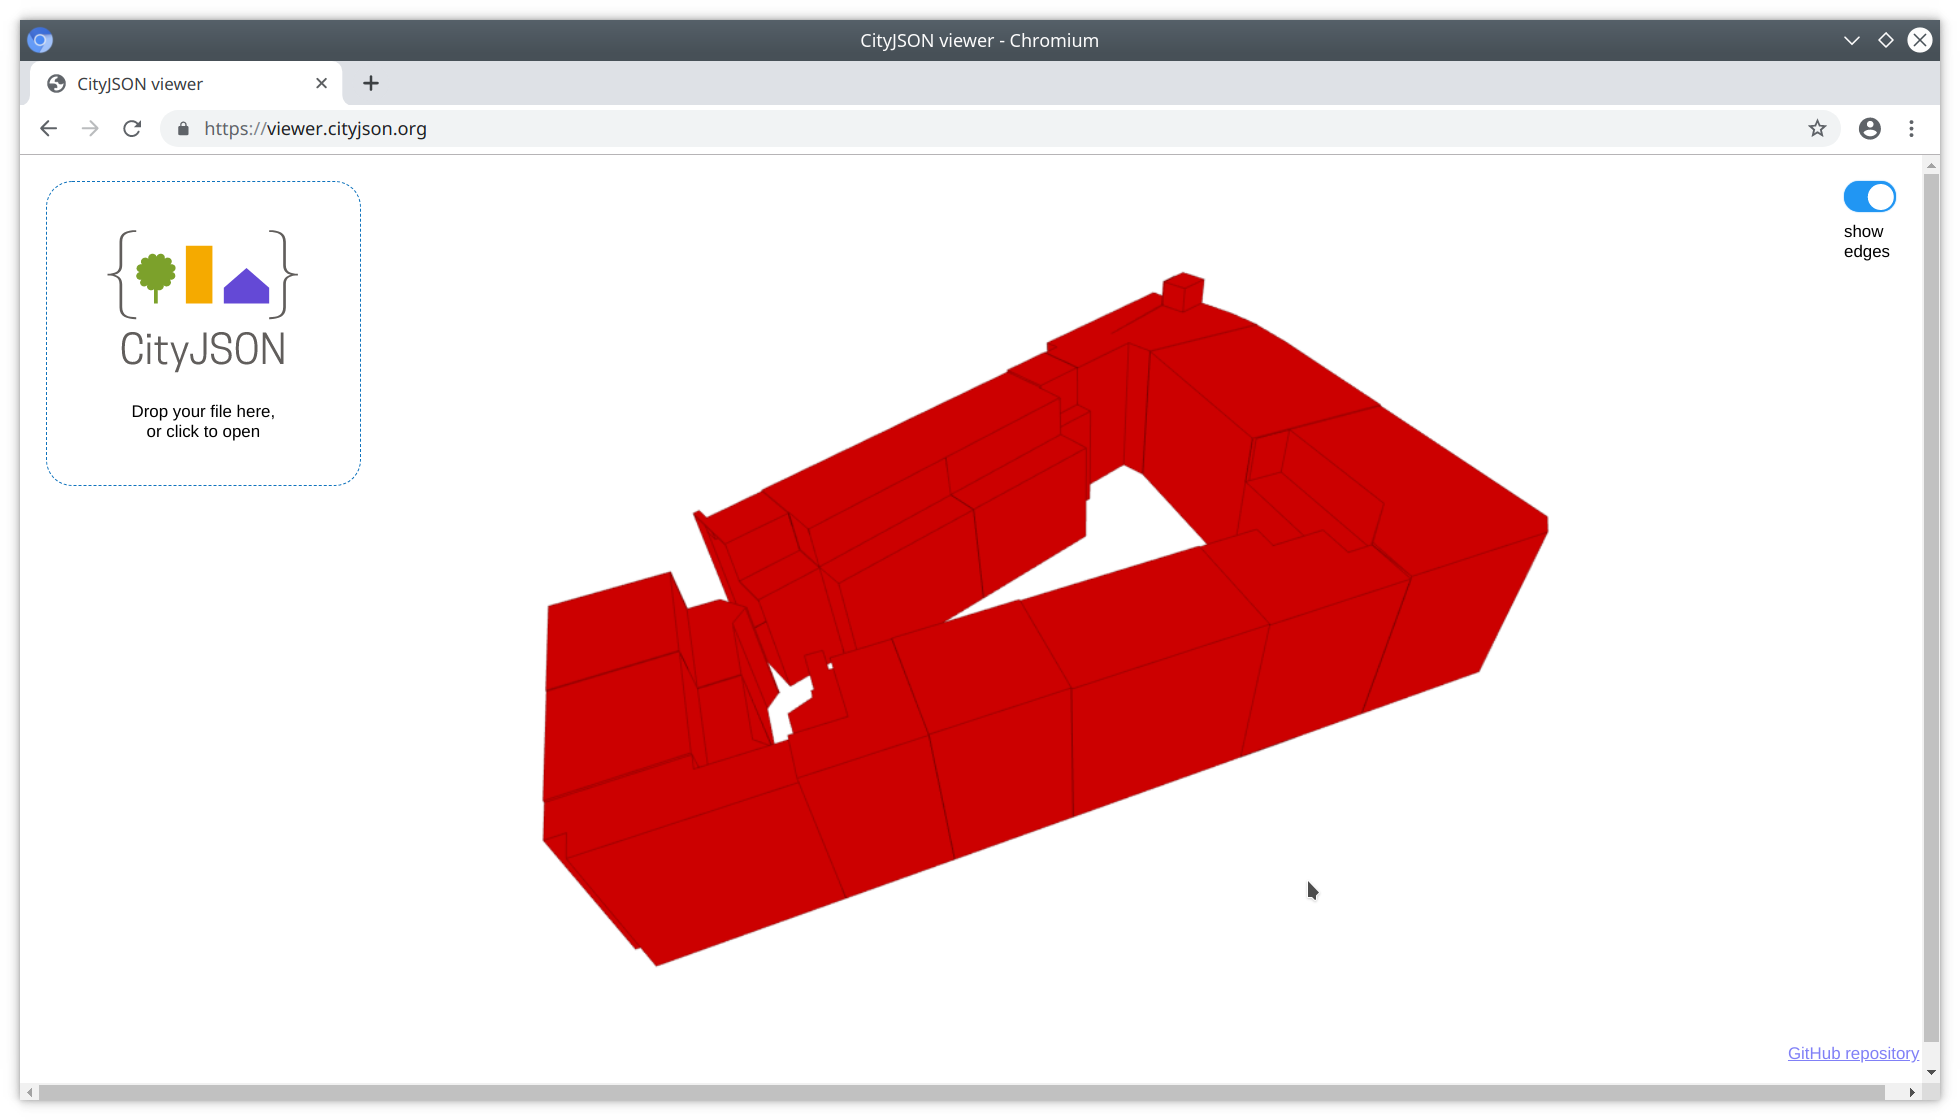

The `load()` method loads a CityJSON file into a CityJSON object.

In [3]:
path = data_dir / 'rotterdam' / 'rotterdam_subset.json'
cm = cityjson.load(path)
print(type(cm))

<class 'cjio.cityjson.CityJSON'>


## Using the CLI commands in the API
You can use any of the CLI commands on a CityJSON object. However, not all CLI commands are mapped 1-to-1 to CityJSON methods, plus you need to provide the parameters yourself. The reason for this is that the CLI commands are wrapper functions that take care of passing parameters and parsing outputs. And we haven't harmonized the CLI and the API yet. 

In [4]:
cm.validate()

-- Validating the syntax of the file
	(using the schemas 1.0.0)
-- Validating the internal consistency of the file (see docs for list)
	--Vertex indices coherent
	--Specific for CityGroups
	--Semantic arrays coherent with geometry
	--Root properties
	--Empty geometries
	--Duplicate vertices
	--Orphan vertices
	--CityGML attributes


(True,
 False,
 [],
 ["WARNING: attributes 'TerrainHeight' not in CityGML schema",
  '\t(16 CityObjects have this warning)',
  "WARNING: attributes 'bron_tex' not in CityGML schema",
  '\t(16 CityObjects have this warning)',
  "WARNING: attributes 'voll_tex' not in CityGML schema",
  '\t(16 CityObjects have this warning)',
  "WARNING: attributes 'bron_geo' not in CityGML schema",
  '\t(16 CityObjects have this warning)',
  "WARNING: attributes 'status' not in CityGML schema",
  '\t(16 CityObjects have this warning)'])

## Explore the city model

We can print the basic information about the city model. Note that `print()` returns the same information as the `info` command in the CLI.

In [5]:
print(cm)

{
  "cityjson_version": "1.0",
  "epsg": 7415,
  "bbox": [
    90454.18900000001,
    435614.88,
    0.0,
    91002.41900000001,
    436048.217,
    18.29
  ],
  "transform/compressed": true,
  "cityobjects_total": 16,
  "cityobjects_present": [
    "Building"
  ],
  "materials": false,
  "textures": true
}


## Working with the objects in the model
### Getting objects from the model
We can get CityObjects by their *type*, or a list of types. Also by their IDs. If no type or ID is provided, `get_cityobjects()` returns all of them, which is equivalent to `cm_r.cityobjects`.

In [6]:
buildings = cm.get_cityobjects(type='building')
buildings_parts = cm.get_cityobjects(type=['building', 'buildingpart'])

r_ids = ['{C9D4A5CF-094A-47DA-97E4-4A3BFD75D3AE}',
         '{6271F75F-E8D8-4EE4-AC46-9DB02771A031}']
buildings_ids = cm.get_cityobjects(id=r_ids)

### Getting the properties and geometry of objects

In [7]:
b01 = buildings_ids['{C9D4A5CF-094A-47DA-97E4-4A3BFD75D3AE}']
print(b01)

{
  "id": "{C9D4A5CF-094A-47DA-97E4-4A3BFD75D3AE}",
  "type": "Building",
  "attributes": {
    "TerrainHeight": 3.03,
    "bron_tex": "UltraCAM-X 10cm juni 2008",
    "voll_tex": "complete",
    "bron_geo": "Lidar 15-30 punten - nov. 2008",
    "status": "1"
  },
  "children": null,
  "parents": null,
  "geometry_type": [
    "MultiSurface"
  ],
  "geometry_lod": [
    2
  ],
  "semantic_surfaces": [
    "RoofSurface",
    "WallSurface",
    "GroundSurface"
  ]
}


The attributes are stored as a dictionary

In [8]:
b01.attributes

{'TerrainHeight': 3.03,
 'bron_tex': 'UltraCAM-X 10cm juni 2008',
 'voll_tex': 'complete',
 'bron_geo': 'Lidar 15-30 punten - nov. 2008',
 'status': '1'}

CityObjects can have *children* and *parents*

In [9]:
b01.children is None and b01.parents is None

True

CityObject geometry is a list of `Geometry` objects. That is because a CityObject can have multiple geometry representations in different levels of detail, eg. a geometry in LoD1 and a second geometry in LoD2.

In [10]:
b01.geometry

In [11]:
geom = b01.geometry[0]
print("{}, lod {}".format(geom.type, geom.lod))

MultiSurface, lod 2


### Geometry boundaries and Semantic Surfaces
On the contrary to a CityJSON file, the geometry boundaries are dereferenced when working with the API. This means that the vertex coordinates are included in the boundary definition, not only the vertex indices.

`cjio` doesn't provide specific geometry classes (yet), eg. MultiSurface or Solid class. If you are working with the geometry boundaries, you need to the geometric operations yourself, or cast the boundary to a geometry-class of some other library. For example `shapely` if 2D is enough.

Note that although the boundary is dereferenced, we *do not* apply the coordinate transformation to the vertices. The transformed coordinates (integers) take less space in memory. See for example the original (transformed) coordinates below. 

In [12]:
# get the first surface
geom.boundaries[0][0]

[[579471, 198217, 10652],
 [578109, 202330, 10652],
 [577149, 200650, 10652],
 [576461, 200406, 10652],
 [577481, 197515, 10652]]

However, applying the transformation is simply done with the `transform()` method. Also note that the Transformation object is an attribute of the city model.

In [13]:
tranformation_object = cm.transform
geom_tr = geom.transform(tranformation_object)
# get the first surface
geom_tr.boundaries[0][0]


[(90988.79100000001, 435638.657, 10.652000000000001),
 (90987.429, 435642.77, 10.652000000000001),
 (90986.46900000001, 435641.09, 10.652000000000001),
 (90985.781, 435640.846, 10.652000000000001),
 (90986.801, 435637.955, 10.652000000000001)]

In case you want to transform the whole city model, the best if you apply the transformation when loading it. Note that `"transform/compressed": false`.

In [14]:
cm_transformed = cityjson.load(path, transform=True)
print(cm_transformed)

{
  "cityjson_version": "1.0",
  "epsg": 7415,
  "bbox": [
    90454.18900000001,
    435614.88,
    0.0,
    91002.41900000001,
    436048.217,
    18.29
  ],
  "transform/compressed": false,
  "cityobjects_total": 16,
  "cityobjects_present": [
    "Building"
  ],
  "materials": false,
  "textures": true
}


Semantic Surfaces are stored in a similar fashion as in a CityJSON file, in the `surfaces` attribute of a Geometry object.

In [15]:
geom.surfaces

{0: {'surface_idx': [[0], [1], [2]], 'type': 'RoofSurface'},
 1: {'surface_idx': [[3]], 'type': 'GroundSurface'},
 2: {'surface_idx': [[4],
   [5],
   [6],
   [7],
   [8],
   [9],
   [10],
   [11],
   [12],
   [13],
   [14],
   [15],
   [16],
   [17],
   [18],
   [19]],
  'type': 'WallSurface'}}

The main difference is the presence of the `surface_idx` property. The `surface_idx` is used by the `get_surface_boundaries()` method to efficiently extract the relevant geometry boundaries.

In [16]:
roofs = geom.get_surfaces(type='roofsurface')
roofs

{0: {'surface_idx': [[0], [1], [2]], 'type': 'RoofSurface'}}

In [17]:
roof_boundaries = []
for r in roofs.values():
    roof_boundaries.append(geom.get_surface_boundaries(r))
roof_boundaries

[[[[[579471, 198217, 10652],
    [578109, 202330, 10652],
    [577149, 200650, 10652],
    [576461, 200406, 10652],
    [577481, 197515, 10652]]],
  [[[580840, 194082, 15211],
    [579471, 198217, 15211],
    [577481, 197515, 15211],
    [576461, 200406, 15211],
    [572239, 198909, 15211],
    [571839, 200119, 15211],
    [571503, 201071, 15211],
    [566651, 199359, 15211],
    [569801, 190223, 15211],
    [573253, 191430, 15211],
    [574658, 191922, 15211]]],
  [[[565589, 202439, 11036],
    [566651, 199359, 11036],
    [571503, 201071, 11036],
    [571839, 200119, 11036],
    [573299, 200640, 11036],
    [572089, 204029, 11036],
    [570629, 203440, 11036],
    [570379, 204150, 11036]]]]]

### Assigning attributes to Semantic Surfaces
In order to change or assign an attribute to the SemanticSurfaces of a CityObject we need to,

1. extract the surfaces,
2. make the changes on the surface,
3. overwrite the CityObjects with the changes.

In [18]:
cm_copy = deepcopy(cm)
new_cos = {}
for co_id, co in cm_copy.cityobjects.items():
    new_geoms = []
    for geom in co.geometry:
        # Only LoD >= 2 models have semantic surfaces
        if geom.lod >= 2.0:
            # Extract the surfaces
            roofsurfaces = geom.get_surfaces('roofsurface')
            for i, rsrf in roofsurfaces.items():
                # Change the attributes
                if 'attributes' in rsrf.keys():
                    rsrf['attributes']['cladding'] = 'tiles'
                else:
                    rsrf['attributes'] = {}
                    rsrf['attributes']['cladding'] = 'tiles'
                geom.surfaces[i] = rsrf
            new_geoms.append(geom)
        else:
            # Use the unchanged geometry
            new_geoms.append(geom)
    co.geometry = new_geoms
    new_cos[co_id] = co
# Overwrite the CityObjects
cm_copy.cityobjects = new_cos

### Create new Semantic Surfaces
The process is similar as previously. However, in this example we create new SemanticSurfaces that hold the values which we compute from the geometry. The input city model has a single semantic "WallSurface", without attributes, for all the walls of a building. The snippet below illustrates how to separate surfaces and assign the semantics to them.

In [19]:
new_cos = {}

for co_id, co in cm_copy.cityobjects.items():
    new_geoms = []
    
    for geom in co.geometry:
        if geom.lod >= 2.0:
            max_id = max(geom.surfaces.keys())
            old_ids = []
            
            for w_i, wsrf in geom.get_surfaces('wallsurface').items():
                old_ids.append(w_i)
                del geom.surfaces[w_i]
                boundaries = geom.get_surface_boundaries(wsrf)
                
                for j, boundary_geometry in enumerate(boundaries):
                    # The original geometry has the same Semantic for all wall, 
                    # but we want to divide the wall surfaces by their orientation, 
                    # thus we need to have the correct surface index
                    surface_index = wsrf['surface_idx'][j]
                    new_srf = {
                        'type': wsrf['type'],
                        'surface_idx': surface_index
                    }
                    
                    for multisurface in boundary_geometry:
                        # Do any operation here
                        x, y, z = multisurface[0]
                        if j % 2 > 0:
                            orientation = 'north'
                        else:
                            orientation = 'south'
                        
                        # Add the new attribute to the surface 
                        if 'attributes' in wsrf.keys():
                            wsrf['attributes']['orientation'] = orientation
                        else:
                            wsrf['attributes'] = {}
                            wsrf['attributes']['orientation'] = orientation
                        
                        new_srf['attributes'] = wsrf['attributes']
                        
                        # if w_i in geom.surfaces.keys():
                        #     del geom.surfaces[w_i]
                        
                        max_id = max_id + 1
                        geom.surfaces[max_id] = new_srf
                        
            new_geoms.append(geom)
            
        else:
            # If LoD1, just add the geometry unchanged
            new_geoms.append(geom)
            
    co.geometry = new_geoms
    new_cos[co_id] = co
    
cm_copy.cityobjects = new_cos

## Save or Export
At the end, the `save()` method saves the edited city model into a CityJSON file.

In [20]:
p_out = data_dir / 'test_output.json'
cityjson.save(cm_copy, p_out)